In [24]:
import gmplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
Data = pd.read_csv('./GPS Data/CBR30_CBrace.csv')

In [66]:
Data

,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z
0,1,1,FIXED,1/13/2017,19:44:04,1/13/2017,13:44:04,0,41.797036,N,88.201552,W,150.061157,0.371595,140.581840,0,0,0
1,2,1,FIXED,1/13/2017,19:44:14,1/13/2017,13:44:14,0,41.796991,N,88.201503,W,150.000107,0.347476,291.282261,0,0,0
2,3,1,FIXED,1/13/2017,19:44:24,1/13/2017,13:44:24,0,41.797028,N,88.201629,W,150.000504,0.168644,261.493957,0,0,0
3,4,1,FIXED,1/13/2017,19:44:34,1/13/2017,13:44:34,0,41.796972,N,88.202133,W,190.271286,0.034901,66.216543,0,0,0
4,5,1,FIXED,1/13/2017,19:44:44,1/13/2017,13:44:44,0,41.796976,N,88.202120,W,189.259796,0.082576,351.582684,0,0,0
5,6,1,FIXED,1/13/2017,19:44:54,1/13/2017,13:44:54,0,41.796976,N,88.202120,W,189.009933,0.031244,317.415644,0,0,0
6,7,1,FIXED,1/13/2017,19:45:04,1/13/2017,13:45:04,0,41.796976,N,88.202120,W,188.768280,0.024499,165.538333,0,0,0
7,8,1,FIXED,1/13/2017,19:45:14,1/13/2017,13:45:14,0,41.796976,N,88.202120,W,188.629547,0.078315,99.785845,0,0,0
8,9,1,FIXED,1/13/2017,19:45:24,1/13/2017,13:45:24,0,41.796976,N,88.202120,W,188.545609,0.055042,45.013975,0,0,0
9,10,1,FIXED,1/13/2017,19:45:34,1/13/2017,13:45:34,0,41.796976,N,88.202119,W,188.516815,0.038155,73.426547,0,0,0


In [67]:
Lat = Data.LATITUDE
Lon = Data.LONGITUDE

In [68]:
Data.loc[Data.iloc[:,11]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,11]=="W","LONGITUDE"]*-1

In [69]:
gmap = gmplot.GoogleMapPlotter(41.894939,-87.617634,12)

In [70]:
gmap.heatmap(Lat,Lon, threshold=1, radius=100)
gmap.scatter(Lat[1:5000],Lon[1:5000],'k', size=40, marker=False)

In [71]:
gmap.draw("testCBR.html")

## Clustering

In [2]:
Data = pd.read_csv('./GPS Data/CBR30_CBrace.csv')

In [3]:
Data

,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z
0,1,1,FIXED,1/13/2017,19:44:04,1/13/2017,13:44:04,0,41.797036,N,88.201552,W,150.061157,0.371595,140.581840,0,0,0
1,2,1,FIXED,1/13/2017,19:44:14,1/13/2017,13:44:14,0,41.796991,N,88.201503,W,150.000107,0.347476,291.282261,0,0,0
2,3,1,FIXED,1/13/2017,19:44:24,1/13/2017,13:44:24,0,41.797028,N,88.201629,W,150.000504,0.168644,261.493957,0,0,0
3,4,1,FIXED,1/13/2017,19:44:34,1/13/2017,13:44:34,0,41.796972,N,88.202133,W,190.271286,0.034901,66.216543,0,0,0
4,5,1,FIXED,1/13/2017,19:44:44,1/13/2017,13:44:44,0,41.796976,N,88.202120,W,189.259796,0.082576,351.582684,0,0,0
5,6,1,FIXED,1/13/2017,19:44:54,1/13/2017,13:44:54,0,41.796976,N,88.202120,W,189.009933,0.031244,317.415644,0,0,0
6,7,1,FIXED,1/13/2017,19:45:04,1/13/2017,13:45:04,0,41.796976,N,88.202120,W,188.768280,0.024499,165.538333,0,0,0
7,8,1,FIXED,1/13/2017,19:45:14,1/13/2017,13:45:14,0,41.796976,N,88.202120,W,188.629547,0.078315,99.785845,0,0,0
8,9,1,FIXED,1/13/2017,19:45:24,1/13/2017,13:45:24,0,41.796976,N,88.202120,W,188.545609,0.055042,45.013975,0,0,0
9,10,1,FIXED,1/13/2017,19:45:34,1/13/2017,13:45:34,0,41.796976,N,88.202119,W,188.516815,0.038155,73.426547,0,0,0


In [4]:
Lat = Data.LATITUDE
Lon = Data.LONGITUDE

In [5]:
Data.loc[Data.iloc[:,11]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,11]=="W","LONGITUDE"]*-1

In [40]:
dArray = Data[["LATITUDE","LONGITUDE"]].values

In [7]:
from sklearn.cluster import DBSCAN

In [63]:
dbscan = DBSCAN(metric='haversine', eps=10/6371000, min_samples=500, algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(dArray))
t1 = time.clock()
print(t1-t0)

232.48425551762512


In [64]:
l=clusters.labels_
print(len(l))
np.unique(l)

238573


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [65]:
colors=np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmyk'])

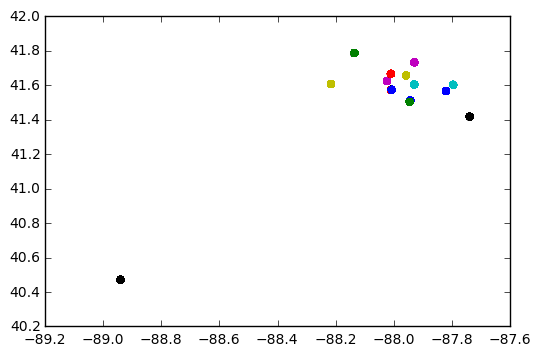

In [66]:
plt.scatter(dArray[l!=-1][:,1],dArray[l!=-1][:,0],color=colors[l[l!=-1]])

In [70]:
m = [np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]

In [92]:
gmap = gmplot.GoogleMapPlotter(41.894939,-87.617634,12)
for c in np.unique(l[l!=-1]):
    m = [np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]
    #s1 = (np.max(dArray[l==c][:,0])-np.min(dArray[l==c][:,0]))*100000
    #s2 = (np.max(dArray[l==c][:,1])-np.min(dArray[l==c][:,1]))*100000
    #print(s1*s2)
    
    s1 = sum(l==c)
    s2=1
    print(s1*s2)
    
    
    gmap.scatter([m[0], m[0]],[m[1], m[1]],color=colors[c], size=s1*s2, marker=False)
gmap.draw("Clusters.html")

155083
11560
16271
1153
3106
968
7004
1405
738
827
949
747
685
877
868


In [71]:
m

[41.574028566541784, -88.007360648491456]

In [79]:
np.std(dArray[l==c][:,0])*np.std(dArray[l==c][:,1])

2.9236992336065863e-09

In [89]:
s1 = sum(l==c)

In [90]:
s1

868